<a href="https://colab.research.google.com/github/handielg/Python/blob/main/Semana_4_Parte_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ahora trabajaremos con imágenes no tan bien estruturadas. Una de las características del generador de imágenes de Tensorflow es que podemos dirigirnos a un directorio, luego a subdirectorios, generando etiquetas para nosotros. Por ejeplo, tenemos una carpeta o directorio de imágenes y en este tenemos subdirectorios de entrenamiento y validación, cuando ponemos nombre a estos subdirectorios, y ponemos las imágenes de cada grupo dentro de estos, el generador de imágenes puede crear un alimentador para estas imágenes y las etiqueta automáticamente.

Por ejemplo si dirijo un generador de imágenes al directorio de entrenamiento, con dos carpetas que digan humanos y caballos, todas las imágenes serán cargadas y etiquetadas como corresponde. Lo mismo podemos hacer con el directorio de entrenamiento.

Veamoslo con código.

In [ ]:
import tensorflow as tf

In [ ]:
#La clase generador de imágenes esta disponible con este código.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Podemos entonces instanciar un generador de imágenes de esta forma.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255) #reescalamos para normalizar los datos.

#El nombre de los subdirectorios que tengamos, serán los nombres de las etiquetas de las imágenes.
#Llmamamos al método flow_from_directory para que cargue las imágenes de ese directorio y los subdirectorios. No lo debemos dirigir al subdirectorio.
# Imágenes de entrenamiento de flujo en lotes de 128 usando el generador train_datagen
train_generator = train_datagen.flow_from_directory(
        train_dir,  # Este es el directorio de origen para las imágenes de entrenamiento.
        target_size=(300, 300),  # Todas las imágenes cambiarán de tamaño a 300x300, las redimensionamos al cargarlas. Esto no afecta las imágenes originales.
        batch_size=128, #tamaño del lote.
       # Dado que usamos pérdida binary_crossentropy, necesitamos etiquetas binarias
        class_mode='binary') #para que elija entre 2 cosas, mas adelante veremos otras.

Como podemos ver este código es similar al de la semana pasada. En este caso hay más capas de convlución y pooling, por el tamaño y complejidad de las imágenes.

In [ ]:
model = tf.keras.models.Sequential([
    # Tenga en cuenta que la forma de entrada es el tamaño deseado de la imagen 300x300 con 3 bytes de color
    # Esta es la primera convolución
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)), #como son de colores, las redimensionamos a 3 bytes por pixel, 1 para el rojo, 1 azul y 1 para el verde.
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Solo 1 neurona de salida. Contendrá un valor de 0-1 donde 0 para 1 clase ('caballos') y 1 para la otra ('humanos')
    tf.keras.layers.Dense(1, activation='sigmoid') #solo una neurona para 2 clases. Usamos la función sigmoide porque es muy buena para clasificación binaria. Cuando una clase tiende a 0, la otra a 1.
])

In [ ]:
model.summary() #como podmeos ver terminamos en imágenes de 7x7. Una vez que los datos salen de las convoluciones, son aplanados a 3136 valores.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        3

In [ ]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy', #función de pérdida. Escogemos esta porque es clasificación binaria.
              optimizer=RMSprop(lr=0.001), #optimizador. Con este podemos ajustar la tasa de aprendizaje para experimentar con el rendimiento.
              metrics=['accuracy'])

###Entrenamiento

Entrenemos durante 15 épocas; esto puede tardar unos minutos en ejecutarse.

Tenga en cuenta los valores por época.

La pérdida y la precisión son una gran indicación del progreso del entrenamiento. Se trata de adivinar la clasificación de los datos de entrenamiento y luego compararlos con la etiqueta conocida para calcular el resultado. La precisión es la parte de las conjeturas correctas.

In [ ]:
history = model.fit(
      train_generator, #este es el train_generator que configuramos anteriormente. Este hace fluir las imágenes desde el directorio. 
      steps_per_epoch=8, #dijimos que batch_size = 128, debemos dividir la cantidad total de imágenes entre 128 para encontrar steps_per_epoch.
      epochs=15, #número de epoch para entrenar.
      verbose=2, #especifica cuanto se muestra en el entrenamiento, en 2, obtenemos menos animación ocultando el progreso del epoch. Con 1 más.
      validation_data = validation_generator, #especificamos el conjunto de validación.
      validation_steps=8) #si tenemos 256 imágenes y las usaremos en lotes de 32, necesitamos 8 pasos.

###Ejecutando el modelo
Echemos ahora un vistazo a la ejecución real de una predicción utilizando el modelo. Este código le permitirá elegir 1 o más archivos de su sistema de archivos, luego los cargará y los ejecutará a través del modelo, dando una indicación de si el objeto es un caballo o un humano.

In [ ]:
import numpy as np
from google.colab import files #nos permite importar datos.
from keras.preprocessing import image

uploaded = files.upload() #la ruta de la imagen se carga en este archivo.

for fn in uploaded.keys():
#El bucle itera a través de todas las imágenes de esta colección.
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(300, 300))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10) #este devolverá un vector de clases. Como es binario tendrá valores cercanos a 0 para una clase, y cercano a 1 para la otra.
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a human")
  else:
    print(fn + " is a horse")

#**Ejemplo completo**

In [ ]:
#descargamos el archivo zip que contiene las imágenes.
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /tmp/horse-or-human.zip

--2020-12-02 09:58:57--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.143.128, 173.194.79.128, 108.177.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.143.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M  83.1MB/s    in 1.7s    

2020-12-02 09:58:59 (83.1 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]



El siguiente código de Python usará la biblioteca del sistema operativo para usar las bibliotecas del sistema operativo, lo que le dará acceso al sistema de archivos y la biblioteca zipfile le permitirá descomprimir los datos.

In [ ]:
import os
import zipfile

#Descomprimimos el archivo zip.
local_zip = '/tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/horse-or-human')
zip_ref.close()

El contenido del .zip se extrae al directorio base / tmp / horse-or-human, que a su vez contiene subdirectorios de caballos y humanos.

En resumen: el conjunto de entrenamiento son los datos que se utilizan para decirle al modelo de red neuronal que 'así es como se ve un caballo', 'así es como se ve un humano', etc.

Una cosa a la que hay que prestar atención en esta muestra: no etiquetamos explícitamente las imágenes como caballos o humanos. Si recuerda el ejemplo de escritura a mano anterior, habíamos etiquetado 'esto es un 1', 'esto es un 7', etc. Más tarde verá algo llamado ImageGenerator en uso, y esto está codificado para leer imágenes de subdirectorios, y etiquetarlos automáticamente con el nombre de ese subdirectorio. Entonces, por ejemplo, tendrá un directorio de 'entrenamiento' que contiene un directorio de 'caballos' y uno de 'humanos'. ImageGenerator etiquetará las imágenes apropiadamente para usted, reduciendo un paso de codificación.

Definamos cada uno de estos directorios:

In [ ]:
#El archivo zip contiene 2 carpetas, creamos las variables de entrenamiento.

# Directorio con nuestras fotos de caballos de entrenamiento.
train_horse_dir = os.path.join('/tmp/horse-or-human/horses')
# Directorio con nuestras imágenes de entrenamiento humano.
train_human_dir = os.path.join('/tmp/horse-or-human/humans')

Ahora, veamos cómo se ven los nombres de los archivos en los directorios de entrenamiento de caballos y humanos:

In [ ]:
train_horse_names = os.listdir(train_horse_dir)
print(train_horse_names[:10])

train_human_names = os.listdir(train_human_dir)
print(train_human_names[:10])

['horse31-1.png', 'horse24-1.png', 'horse27-8.png', 'horse46-9.png', 'horse44-3.png', 'horse37-6.png', 'horse28-5.png', 'horse41-8.png', 'horse06-7.png', 'horse12-2.png']
['human01-15.png', 'human03-00.png', 'human07-11.png', 'human10-02.png', 'human03-19.png', 'human09-22.png', 'human15-27.png', 'human12-25.png', 'human15-03.png', 'human16-06.png']


Averigüemos el número total de imágenes de caballos y humanos en los directorios:

In [ ]:
print('total training horse images:', len(os.listdir(train_horse_dir)))
print('total training human images:', len(os.listdir(train_human_dir)))

total training horse images: 500
total training human images: 527



Ahora echemos un vistazo a algunas imágenes para tener una mejor idea de cómo se ven. Primero, configure los parámetros de matplot:

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parámetros para nuestro gráfico; emitiremos imágenes en una configuración 4x4
nrows = 4
ncols = 4
# Índice para iterar sobre imágenes
pic_index = 0

Ahora, muestre un lote de 8 imágenes de caballos y 8 humanas. Puede volver a ejecutar la celda para ver un lote nuevo cada vez:

In [ ]:
#Imprimimos algunas imágenes
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_horse_pix = [os.path.join(train_horse_dir, fname) 
                for fname in train_horse_names[pic_index-8:pic_index]]
next_human_pix = [os.path.join(train_human_dir, fname) 
                for fname in train_human_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_horse_pix+next_human_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

###Construyendo un modelo pequeño desde cero¶
Pero antes de continuar, comencemos a definir el modelo:

El paso 1 será importar tensorflow.

In [ ]:
import tensorflow as tf

Luego agregamos capas convolucionales como en el ejemplo anterior y aplanamos el resultado final para alimentar las capas densamente conectadas.

Finalmente agregamos las capas densamente conectadas.

Tenga en cuenta que debido a que nos enfrentamos a un problema de clasificación de dos clases, es decir, un problema de clasificación binaria, terminaremos nuestra red con una activación sigmoidea, de modo que la salida de nuestra red será un solo escalar entre 0 y 1, codificando la probabilidad de que la imagen actual es de clase 1 (a diferencia de la clase 0).

In [ ]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

La llamada al método model.summary () imprime un resumen de la NN

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        3

La columna "forma de salida" muestra cómo evoluciona el tamaño de su mapa de características en cada capa sucesiva. Las capas de convolución reducen un poco el tamaño de los mapas de características debido al relleno, y cada capa de agrupación reduce a la mitad las dimensiones.

A continuación, configuraremos las especificaciones para el entrenamiento de modelos. Entrenaremos nuestro modelo con la pérdida de binary_crossentropy, porque es un problema de clasificación binaria y nuestra activación final es sigmoidea. (Para un repaso sobre las métricas de pérdida, consulte el [Curso intensivo de aprendizaje automático](https://developers.google.com/machine-learning/crash-course/descending-into-ml/video-lecture)). Usaremos el optimizador rmsprop con una tasa de aprendizaje de 0,001. Durante el entrenamiento, queremos monitorear la precisión de la clasificación.

NOTA: En este caso, usar el algoritmo de optimización RMSprop es preferible al descenso de gradiente estocástico [SGD](https://developers.google.com/machine-learning/glossary/#SGD), porque [RMSprop](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp) automatiza el ajuste de la tasa de aprendizaje para nosotros. (Otros optimizadores, como [Adam](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam) y [Adagrad](https://developers.google.com/machine-learning/glossary/#AdaGrad), también adaptan automáticamente la tasa de aprendizaje durante el entrenamiento y funcionarían igualmente bien aquí).


[Binary Cross-Entropy Loss](https://gombru.github.io/2018/05/23/cross_entropy_loss/)

[RMSprop Optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/RMSprop)

[RMSprop](http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf)




In [ ]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy', #porque usamos 2 clases.
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])

###Preprocesamiento de datos.

Configuremos generadores de datos que leerán imágenes en nuestras carpetas de origen, las convertirán en tensores float32 y las alimentarán (con sus etiquetas) a nuestra red. Tendremos un generador para las imágenes de entrenamiento y otro para las imágenes de validación. Nuestros generadores producirán lotes de imágenes de tamaño 300x300 y sus etiquetas (binarias).

Como ya sabrá, los datos que ingresan a las redes neuronales generalmente deben normalizarse de alguna manera para que sean más fáciles de procesar por la red. (Es poco común introducir píxeles sin procesar en una convnet). En nuestro caso, procesaremos previamente nuestras imágenes normalizando los valores de los píxeles para que estén en el rango `[0, 1]` (originalmente todos los valores están en el rango` [0, 255]` ).

En Keras, esto se puede hacer a través de la clase `keras.preprocessing.image.ImageDataGenerator `usando el parámetro `rescale`. Esta clase `ImageDataGenerator` le permite crear instancias de generadores de lotes de imágenes aumentadas (y sus etiquetas) a través de `.flow(data, labels)`  o .`.flow_from_directory(directory)`. Estos generadores se pueden usar con los métodos del modelo de Keras que aceptan generadores de datos como entradas: `fit, evaluate_generator, and predict_generator`.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255) #escalamos las imágenes, para normalizar los valores.

#Flujo de las Imágenes de entrenamiento en lotes de 128 utilizando train_datagen generador
train_generator = train_datagen.flow_from_directory(
        '/tmp/horse-or-human/',  # Este es el directorio de las imágenes de entrenamiento. Ruta del archivo descomprimido.
        target_size=(300, 300),  # Todas las imágenes son reconvertidas a 300x300.
        batch_size=128,
        # Dado que usamos pérdida binary_crossentropy, necesitamos etiquetas binarias
        class_mode='binary')

Found 1027 images belonging to 2 classes.


###Entrenamiento

Entrenemos durante 15 épocas; esto puede tardar unos minutos en ejecutarse.

Tenga en cuenta los valores por época.

La pérdida y la precisión son una gran indicación del progreso del entrenamiento. Se trata de adivinar la clasificación de los datos de entrenamiento y luego compararlos con la etiqueta conocida para calcular el resultado. La precisión es la parte de las conjeturas correctas.

In [ ]:
#Solicitamos GPU
%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0': #esto es lo que nos debe salir si nos asignan GPU.
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Cada epoch carga los datos, calculando las convoluciones, 

In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=8,  
      epochs=15,
      verbose=2)

Epoch 1/15
8/8 - 5s - loss: 0.0226 - accuracy: 0.9978
Epoch 2/15
8/8 - 5s - loss: 0.0129 - accuracy: 0.9989
Epoch 3/15
8/8 - 5s - loss: 0.0055 - accuracy: 1.0000
Epoch 4/15
8/8 - 6s - loss: 0.0057 - accuracy: 0.9990
Epoch 5/15
8/8 - 5s - loss: 0.0020 - accuracy: 1.0000
Epoch 6/15
8/8 - 5s - loss: 9.2055e-04 - accuracy: 1.0000
Epoch 7/15
8/8 - 5s - loss: 9.7598e-04 - accuracy: 1.0000
Epoch 8/15
8/8 - 5s - loss: 2.5410e-04 - accuracy: 1.0000
Epoch 9/15
8/8 - 5s - loss: 1.5214e-04 - accuracy: 1.0000
Epoch 10/15
8/8 - 5s - loss: 1.2206e-04 - accuracy: 1.0000
Epoch 11/15
8/8 - 5s - loss: 2.6968 - accuracy: 0.9177
Epoch 12/15
8/8 - 5s - loss: 0.0852 - accuracy: 0.9700
Epoch 13/15
8/8 - 5s - loss: 0.0083 - accuracy: 1.0000
Epoch 14/15
8/8 - 5s - loss: 0.0021 - accuracy: 1.0000
Epoch 15/15
8/8 - 5s - loss: 0.0164 - accuracy: 0.9956


###Ejecutando el modelo
Echemos ahora un vistazo a la ejecución real de una predicción utilizando el modelo. Este código le permitirá elegir 1 o más archivos de su sistema de archivos, luego los cargará y los ejecutará a través del modelo, dando una indicación de si el objeto es un caballo o un humano.

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(300, 300))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " es una persona")
  else:
    print(fn + " es un caballo")

Saving model-2387582_1920.jpg to model-2387582_1920 (1).jpg
Saving poor-1775239_640.jpg to poor-1775239_640 (1).jpg
Saving woman-1979272_640.jpg to woman-1979272_640 (2).jpg
Saving woman-837156_640.jpg to woman-837156_640 (2).jpg
Saving dfghjs.jpg to dfghjs (1).jpg
[2.0575756e-35]
model-2387582_1920.jpg es un caballo
[0.]
poor-1775239_640.jpg es un caballo
[0.]
woman-1979272_640.jpg es un caballo
[0.]
woman-837156_640.jpg es un caballo
[0.]
dfghjs.jpg es un caballo


###Visualización de representaciones intermedias¶
Para tener una idea de qué tipo de características ha aprendido nuestro convnet, una cosa divertida es visualizar cómo se transforma una entrada a medida que pasa por el convnet.

Escojamos una imagen aleatoria del conjunto de entrenamiento y luego generemos una figura donde cada fila es el resultado de una capa, y cada imagen de la fila es un filtro específico en ese mapa de características de salida. Vuelva a ejecutar esta celda para generar representaciones intermedias para una variedad de imágenes de entrenamiento.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


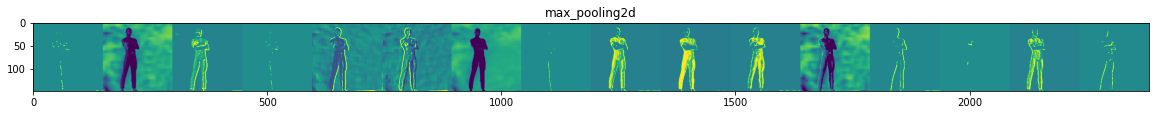

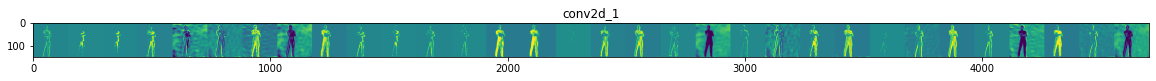

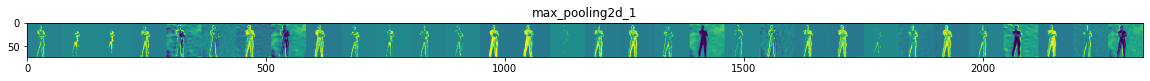

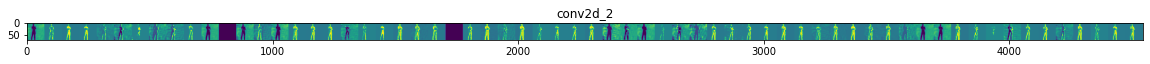

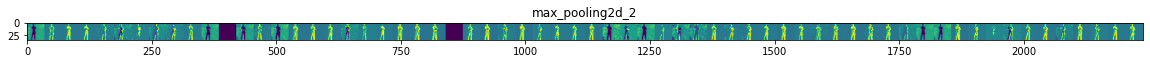

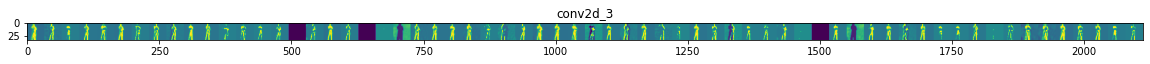

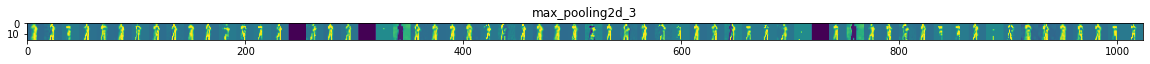

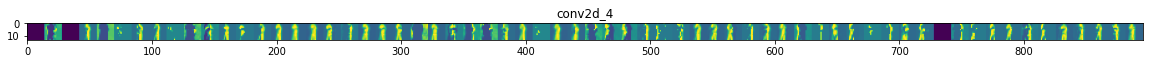

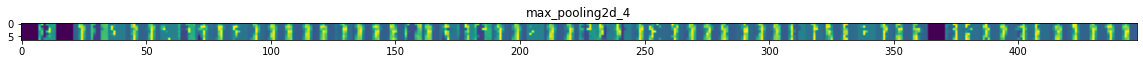

In [ ]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
# Let's prepare a random input image from the training set.
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)

img = load_img(img_path, target_size=(300, 300))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers[1:]]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

Como ves pasamos de los píxeles en bruto de las imágenes a representaciones cada vez más abstractas y compactas. Las representaciones en sentido descendente comienzan a resaltar aquello a lo que la red presta atención y muestran cada vez menos funciones que se "activan"; la mayoría se ponen a cero. A esto se le llama "escasez". La escasez de representación es una característica clave del aprendizaje profundo.

Estas representaciones llevan cada vez menos información sobre los píxeles originales de la imagen, pero información cada vez más refinada sobre la clase de la imagen. Puede pensar en un convnet (o una red profunda en general) como una tubería de destilación de información.

###Limpiar

Antes de ejecutar el siguiente ejercicio, ejecute la siguiente celda para terminar el kernel y liberar recursos de memoria:

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)